In [59]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import  matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
import torchvision
from torchmetrics.classification import Accuracy
import warnings
warnings.filterwarnings("ignore")
import gradio as gr
import tqdm as notebook_tqdm

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),                # convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # normalization
])

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

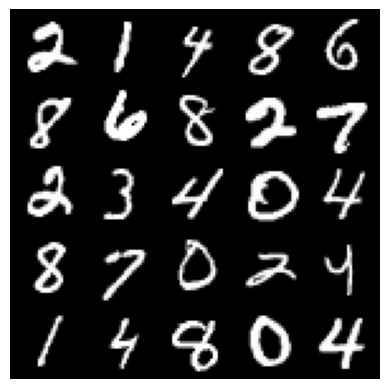

In [4]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:25], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

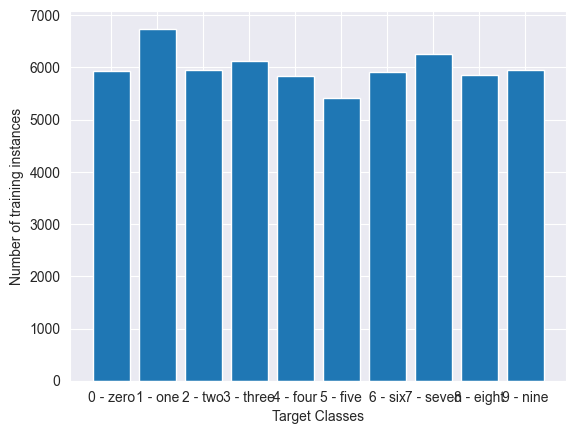

In [6]:
classes = []
for batch_idx, data in enumerate(train_loader):
    x, y = data
    classes.extend(y.tolist())

unique, counts = np.unique(classes, return_counts=True)
names = list(test_dataset.class_to_idx.keys())
plt.bar(names, counts)
plt.xlabel("Target Classes")
plt.ylabel("Number of training instances")
plt.show()

In [7]:
class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, 256), nn.Linear(256, 128), nn.Linear(128, 64), nn.Linear(64, output_size)])
        self.relu = nn.ReLU()

    def forward(self, x):
        for i , layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.relu(x)
        return x

model = NN(input_size=784, output_size=10)

In [8]:
class NN1(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(input_size, 256), nn.BatchNorm1d(256), nn.ReLU()),
            nn.Sequential(nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU()),
            nn.Sequential(nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU()),
            nn.Linear(64, output_size)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

model1 = NN1(input_size=784, output_size=10)

In [9]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [10]:
def train_val(model, criterion, optimizer, train_loader, test_loader, num_epochs):
    val_loss = []
    train_loss = []

    accuracy = Accuracy(task="multiclass", num_classes=10).to(DEVICE)

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            if isinstance(model, NN):
                X_batch = X_batch.view(X_batch.size(0), -1)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        train_epoch_loss = np.mean(train_losses)
        train_loss.append(train_epoch_loss)


        model.eval()
        acc_val = []
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

                if isinstance(model, NN):
                    X_batch = X_batch.view(X_batch.size(0), -1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                proba = torch.softmax(outputs, dim = 1)
                batch_accuracy = accuracy(proba, y_batch)
                acc_val.append(batch_accuracy.item())

                val_losses.append(loss.item())

        val_epoch_loss = np.mean(val_losses)
        val_loss.append(val_epoch_loss)

        print(f'Epoch {epoch+1}, Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')

        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    early_stopping.load_best_model(model)
    return train_loss, val_loss, acc_val

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, delta=0.01)

In [12]:
train_loss, val_loss, acc_val = train_val(model, criterion, optimizer, train_loader, test_loader, 10)

Epoch 1, Train Loss: 0.3673, Val Loss: 0.1998
Epoch 2, Train Loss: 0.1599, Val Loss: 0.1267
Epoch 3, Train Loss: 0.1175, Val Loss: 0.1075
Epoch 4, Train Loss: 0.0936, Val Loss: 0.0984
Epoch 5, Train Loss: 0.0827, Val Loss: 0.0911
Epoch 6, Train Loss: 0.0714, Val Loss: 0.0818
Epoch 7, Train Loss: 0.0637, Val Loss: 0.0874
Epoch 8, Train Loss: 0.0577, Val Loss: 0.0842
Epoch 9, Train Loss: 0.0521, Val Loss: 0.0926
Epoch 10, Train Loss: 0.0470, Val Loss: 0.0765


In [13]:
acc = np.mean(acc_val)
print(f"Accuracy: {acc:.3f}")

Accuracy: 0.978


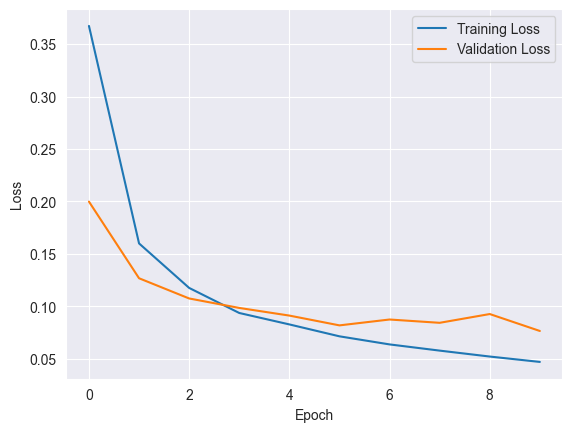

In [14]:
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Using ConvNN

In [7]:
class ConvNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels= 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))     # [B, 32, 14, 14]
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
cnn_model = ConvNN()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

In [16]:
early_stopping = EarlyStopping(patience=5, delta=0.01)

train_loss, val_loss, acc_val = train_val(cnn_model, criterion, optimizer_cnn, train_loader, test_loader, 10)

Epoch 1, Train Loss: 0.1312, Val Loss: 0.0502
Epoch 2, Train Loss: 0.0486, Val Loss: 0.0420
Epoch 3, Train Loss: 0.0358, Val Loss: 0.0338
Epoch 4, Train Loss: 0.0258, Val Loss: 0.0399
Epoch 5, Train Loss: 0.0214, Val Loss: 0.0467
Epoch 6, Train Loss: 0.0187, Val Loss: 0.0412
Epoch 7, Train Loss: 0.0152, Val Loss: 0.0339
Epoch 8, Train Loss: 0.0137, Val Loss: 0.0355
Early stopping


In [17]:
acc = np.mean(acc_val)
print(f"Accuracy: {acc:.3f}")

Accuracy: 0.991


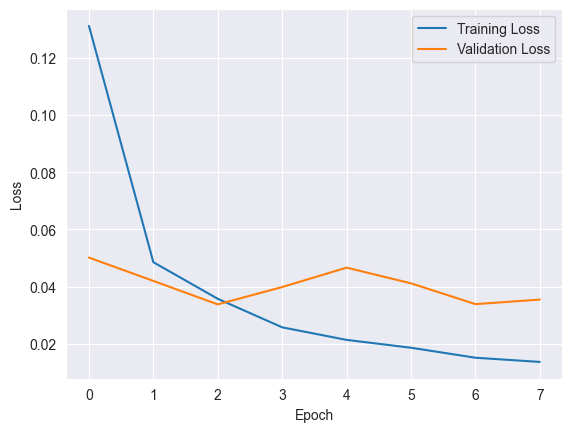

In [18]:
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

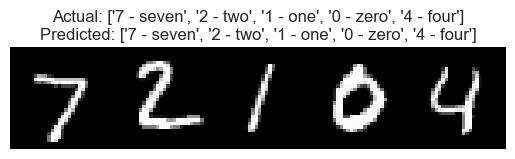

In [19]:
images, labels = next(iter(test_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

outputs = cnn_model(images)
proba = torch.softmax(outputs, dim=1)

# Берём первые 5
num_images = 5
y_true = labels[:num_images]
y_pred = torch.argmax(proba, dim=1)[:num_images]

# Преобразуем в имена
y_true_name = [names[int(y)] for y in y_true]
y_pred_name = [names[int(y)] for y in y_pred]

# Заголовок
title = f"Actual: {y_true_name}\nPredicted: {y_pred_name}"

# Визуализация
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:num_images].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))
plt.title(title)
plt.axis("off")
plt.show()


In [20]:
from sklearn.metrics import classification_report

predictions = []
real_labels = []

cnn_model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE).float()
        out_class = cnn_model(x)

        preds = torch.argmax(out_class, dim=1)

        predictions.extend(preds.cpu().numpy())
        real_labels.extend(y.cpu().numpy())

# Теперь делаем отчёт
print(classification_report(real_labels, predictions, target_names=names))

              precision    recall  f1-score   support

    0 - zero       0.98      1.00      0.99       980
     1 - one       0.99      1.00      1.00      1135
     2 - two       0.99      0.99      0.99      1032
   3 - three       0.99      0.98      0.99      1010
    4 - four       1.00      0.99      0.99       982
    5 - five       0.99      0.99      0.99       892
     6 - six       1.00      0.99      0.99       958
   7 - seven       0.99      0.99      0.99      1028
   8 - eight       0.99      0.98      0.99       974
    9 - nine       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [54]:
torch.save(cnn_model.state_dict(), "cnn_model.pt")

cnn_model.eval()
example_input = torch.randn(1, 1, 28, 28).to(DEVICE)
traced = torch.jit.trace(cnn_model.to(DEVICE), example_input)
torch.jit.save(traced, "cnn_model_scripted.pt")

print("Модель сохранена")

Модель сохранена


In [14]:
modell = ConvNN()
modell.load_state_dict(torch.load('cnn_model.pt', weights_only=True))
modell.eval()

ConvNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [55]:
names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
def predict(inp):
    # Get NumPy array from dict
    image_np = inp['composite']  # ← THIS is the correct key!
    transform = transforms.Compose([
        transforms.ToPILImage(),        # ← NumPy → PIL (224x224)
        transforms.Resize((28, 28)),    # ← PIL → 28x28
        transforms.ToTensor(),          # ← PIL → Tensor
        transforms.Lambda(lambda x: 1.0 - x),  # ← Inversion
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Optional: Invert colors (MNIST expects white digits on black bg; sketchpad is often black on white)
    # Add this to transform if your predictions are wrong: transforms.Lambda(lambda x: 1 - x),

    test_imgT = transform(image_np).unsqueeze(0)

    with torch.no_grad():
        modell.eval()
        outputs = modell(test_imgT)
        probs = torch.softmax(outputs, dim=1)
        _, prediction = torch.max(probs, dim=1)
        return f"Predicted digit: {names[int(prediction.item())]}"

In [58]:
interface = gr.Interface(
    fn=predict,
    inputs=gr.Sketchpad(),
    outputs=gr.Textbox(label="Prediction Result"),
    title='Handwritten Digit Recognition',
    description='Draw a digit (0-9) and submit!'
)

interface.launch()

* Running on local URL:  http://127.0.0.1:7883
* To create a public link, set `share=True` in `launch()`.
